In [1]:
import xarray as xr 
import numpy as np
import math 
import glob
import s3fs 
import warnings 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# for map projection:
import cartopy.crs as ccrs

In [2]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, 
                             #combine='by_coords',
                             compat='override')
    return dset

# Location for each mooring: 

- d13: latitude: 81◦24.202’N
       longitude: 31◦13.247’E
- d15: latitude: 81◦24.255’N
       longitude: 31◦13.533’E
- d17: latitude: 81◦24.587’N
       lonitude: 31◦14.506’E
- MB: latitude: 69 N 52.89
      longitude: 011E 11.89
- MW: latitude: 68 N 58.759
      longitude: 013E 16.845 
- MN: latitude: 68 N 56.109
      lonitude: 013E 19.866
- MS: latitude: 68 N 50.128
      longitude: 012E 45.082   
- y1: longitude: 79.37209
      lontitude: 5.57541
- y2: latitude: 80.03876
      longitude: 5.48733
- y3: latitude: 79.44093
      longitude: 5.56333


In [3]:
d15 = open_s3fs('mooring_barents/A-TWAIN_2015-2017_AT200-3_22-118m_ACDP_16640.nc')
d13 = open_s3fs('mooring_barents/A-TWAIN_2013-2015_AT200-2_14-121m_ACDP_16640.nc')
d17 = open_s3fs('mooring_barents/A-TWAIN_2017-2019_AT200-4_20-167m_ACDP_16640.nc')

y1 = open_s3fs('mooring_yermark/Y1.nc')
y2 = open_s3fs('mooring_yermark/Y2.nc')
y3 = open_s3fs('mooring_yermark/Y3.nc')

MB = open_s3fs('mooring_lofoten/PROVOLO_Mooring_MB.nc')
MW = open_s3fs('mooring_lofoten/PROVOLO_Mooring_MW.nc')
MN = open_s3fs('mooring_lofoten/PROVOLO_Mooring_MN.nc')
MS = open_s3fs('mooring_lofoten/PROVOLO_Mooring_MS.nc')

bathym = open_s3fs('bathym.nc')

In [4]:
p_list = [(31.13247,81.24202),(31.13533,81.24255),(31.14506,81.24587)
          ,(011.1189, 69.5289),(013.16845,68.58759),(013.19866,68.56109),(012.45082,68.50128)
          ,(5.57541,79.37209),(5.48733,80.03876),(5.56333,79.44093)]
c_list = ['c', 'orangered', 'g', 'r', 'm', 'y','tab:orange', 'tab:pink', 'limegreen', 'maroon']

In [5]:
'For the mooringsmap to get the depth as approximation for the bathymetry '
ds_rho = xr.open_dataset("https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/density/decav81B0/0.25/woa18_decav81B0_I00_04.nc",
                         decode_times=False
                        ).isel(time=0)

density = ds_rho.I_an.sel(lat=slice(67, 90), lon=slice(-30,35))

depth = density.idxmax(dim="depth", skipna=True)
depth = depth.drop_vars("time")

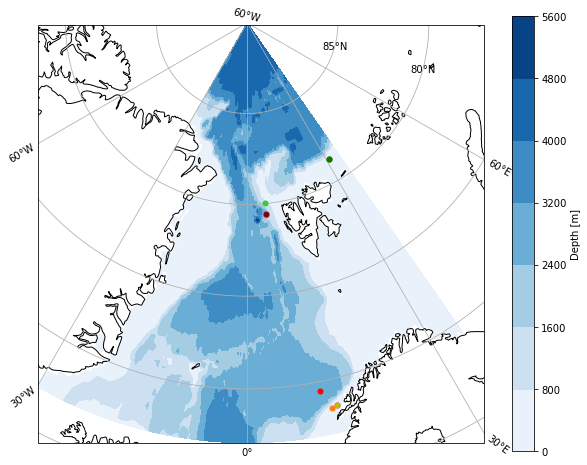

In [6]:
fig, ax = plt.subplots(1, 1,
                       figsize=(10, 8),
                       subplot_kw={"projection" : ccrs.NorthPolarStereo()}
                      )
ax.coastlines()
ax.gridlines(lw=2, ec='black', draw_labels=True)

c = ax.contourf(depth.lon, depth.lat, depth,
                transform=ccrs.PlateCarree(),
                #colors="black",
                #levels=5,
                cmap="Blues"
                )
i = 0
for p in p_list:
    ax.plot(p[0], p[1],
             marker='o', 
             color=c_list[i],
             markersize=5,
             transform=ccrs.PlateCarree(),
             )
    i += 1

fig.colorbar(c,
             shrink=1,
             label=r"Depth [m]"
            )

In [7]:
# Bathymetry
d = bathym.mbathy.isel(x=slice(400,1200), y=slice(900,1800))

# Barents sea
u13 = d13.UCUR.fillna(0).squeeze(axis=0)
v13 = d13.VCUR.fillna(0).squeeze(axis=0)
u15 = d15.UCUR.fillna(0).squeeze(axis=0)
v15 = d15.VCUR.fillna(0).squeeze(axis=0)
u17 = d17.UCUR.fillna(0).squeeze(axis=0)
v17 = d17.VCUR.fillna(0).squeeze(axis=0)

# Lofoten
ub = MB.u.isel(DEPTH=slice(19,-1)).fillna(0)
vb = MB.v.isel(DEPTH=slice(19,-1)).fillna(0)
uw = MW.u.isel(DEPTH=slice(12,-1), TIME=slice(1,-1)).fillna(0)
vw = MW.v.isel(DEPTH=slice(12,-1), TIME=slice(1,-1)).fillna(0)
un = MN.u.isel(DEPTH=slice(7,-1)).fillna(0)
vn = MN.v.isel(DEPTH=slice(7,-1)).fillna(0)
us = MS.u.isel(DEPTH=slice(8,-1)).fillna(0)
vs = MS.v.isel(DEPTH=slice(8,-1)).fillna(0)

# Yermark
u1 = y1.u.isel(DEPTH=slice(11,255), TIME=slice(1,-1)).fillna(0)
v1 = y1.v.isel(DEPTH=slice(11,255), TIME=slice(1,-1)).fillna(0)
u2 = y2.u.isel(DEPTH=slice(4,150), TIME=slice(1,-1)).fillna(0)
v2 = y2.v.isel(DEPTH=slice(4,150), TIME=slice(1,-1)).fillna(0)
u3 = y3.u.isel(DEPTH=slice(11,220), TIME=slice(1,-1)).fillna(0)
v3 = y3.v.isel(DEPTH=slice(11,220), TIME=slice(1,-1)).fillna(0)

vel_l = [(u13,v13),(u15,v15), (u17,v17), (ub,vb),(uw,vw),(un,vn),(us,vs),(u1,v1),(u2,v2),(u3,v3)]
depth_l = [20, ]

In [8]:
def PCz(data):
    cov = np.cov(data.T, bias=True) # uten .T ble den en 73x73 matrise     
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors

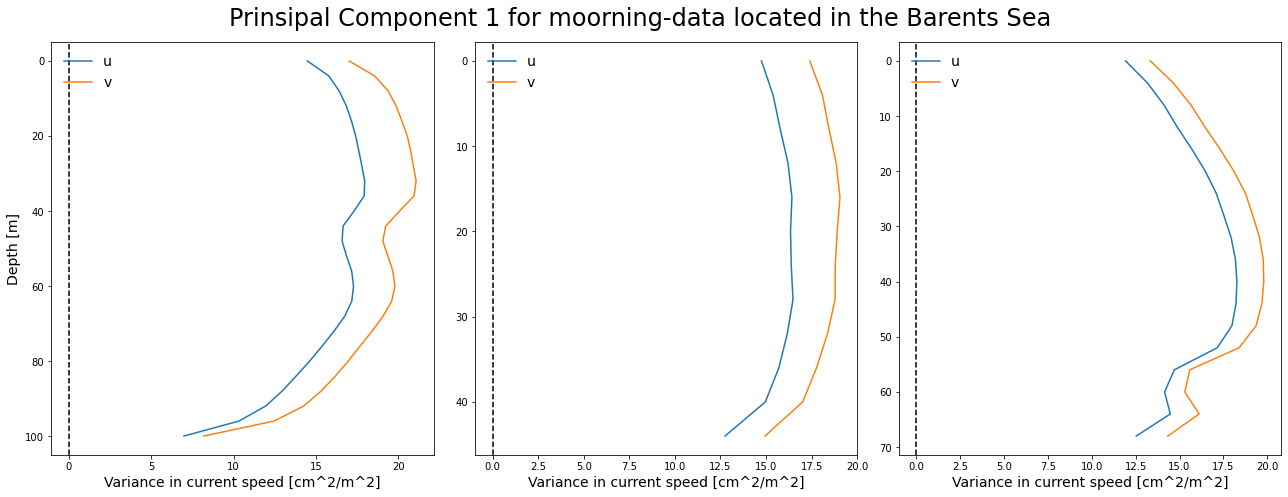

In [9]:
fig, axs = plt.subplots(1,3,figsize=(18,7))
yl = [(u13,v13),(u15,v15),(u17,v17)]
plt.suptitle('Prinsipal Component 1 for moorning-data located in the Barents Sea ', 
             horizontalalignment='center',
            fontsize=24)

axs[0].set_ylabel('Depth [m]', fontsize=14)

for axs, y in zip(axs.flat, yl):
    U =y[0]
    V = y[1]
    valu, vecu = PCz(U)
    valv, vecv = PCz(V)
    axs.plot(np.sqrt(valu[0])*vecu[:,0],U.nDEPTH*4, label= 'u')
    axs.plot(np.sqrt(valv[0])*vecv[:,0],V.nDEPTH*4, label= 'v')
    axs.axvline(0, color='k', linestyle = '--')
    axs.invert_yaxis()
    axs.set_xlabel('Variance in current speed [cm^2/m^2]', fontsize=14)
    axs.legend(frameon=False, fontsize=14, loc="upper left") 
fig.tight_layout()

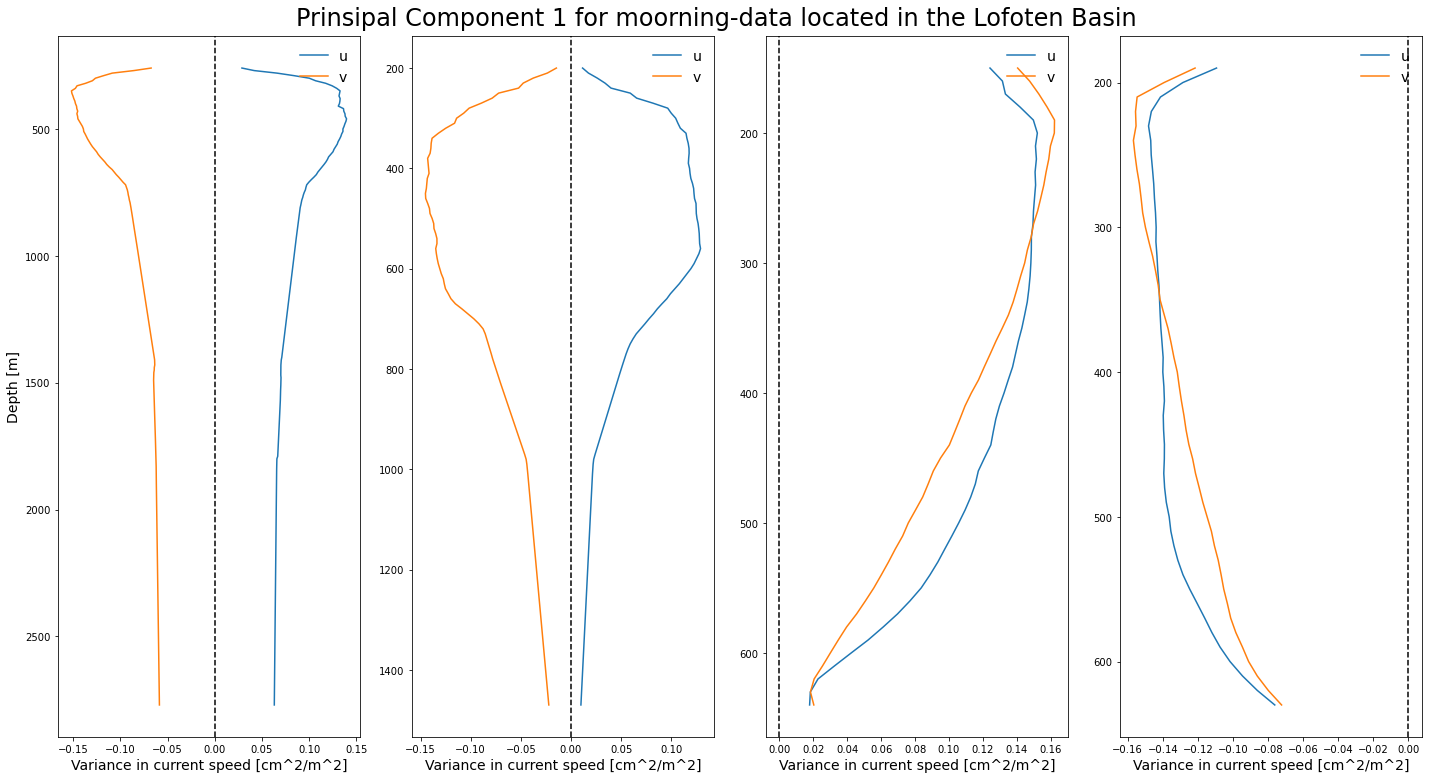

In [10]:
warnings.simplefilter("ignore")
fig, axs = plt.subplots(1,4,figsize=(20,11))
yl = [(ub,vb),(uw,vw),(un,vn),(us,vs)]
plt.suptitle('Prinsipal Component 1 for moorning-data located in the Lofoten Basin', 
             horizontalalignment='center',
            fontsize=24)

axs[0].set_ylabel('Depth [m]', fontsize=14)

for axs, y in zip(axs.flat, yl):
    #for axs, p in zip(axes.flat, range(len((punkt_list)))):
    U =y[0]
    V = y[1]
    valu, vecu = PCz(U)
    valv, vecv = PCz(V)
    axs.plot(np.sqrt(valu[0])*vecu[:,0],U.DEPTH, label= 'u')
    axs.plot(np.sqrt(valv[0])*vecv[:,0],V.DEPTH, label= 'v')
    axs.axvline(0, color='k', linestyle = '--')
    axs.invert_yaxis()
    axs.set_xlabel('Variance in current speed [cm^2/m^2]', fontsize=14)
    axs.legend(frameon=False, fontsize=14, loc="upper right")
fig.tight_layout()

In [11]:
def PCz_yermark(data):
    cov = np.cov(data, bias=True) # uten .T ble den en 73x73 matrise     
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors

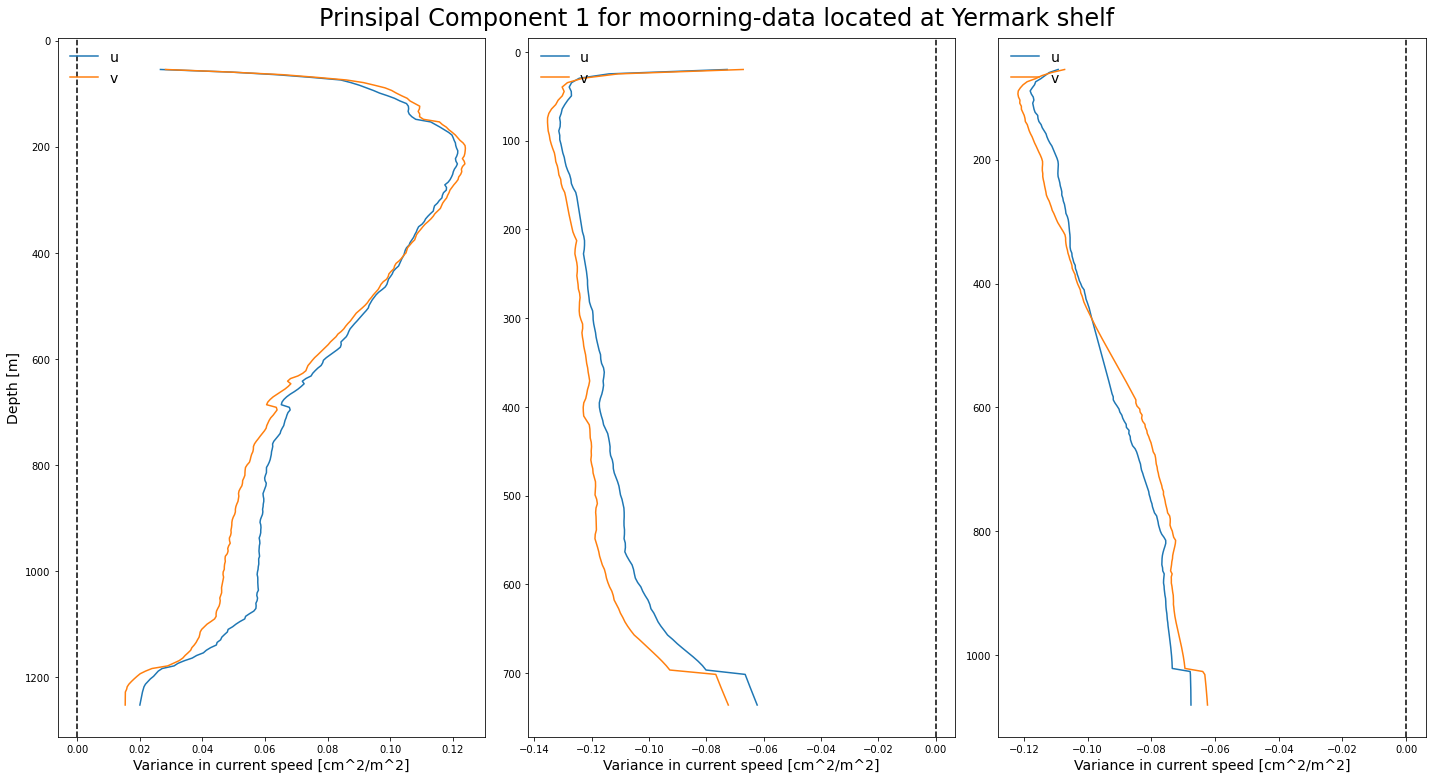

In [12]:
fig, axs = plt.subplots(1,3,figsize=(20,11))
yl = [(u1,v1),(u2,v2),(u3,v3)]
plt.suptitle('Prinsipal Component 1 for moorning-data located at Yermark shelf', 
             horizontalalignment='center',
            fontsize=24)

axs[0].set_ylabel('Depth [m]', fontsize=14)

for axs, y in zip(axs.flat, yl):
    #for axs, p in zip(axes.flat, range(len((punkt_list)))):
    U =y[0]
    V = y[1]
    valu, vecu = PCz_yermark(U)
    valv, vecv = PCz_yermark(V)
    axs.plot(np.sqrt(valu[0])*vecu[:,0],U.DEPTH, label='u')
    axs.plot(np.sqrt(valv[0])*vecv[:,0],V.DEPTH, label='v')
    axs.axvline(0, color='k', linestyle = '--')
    axs.invert_yaxis() 
    axs.set_xlabel('Variance in current speed [cm^2/m^2]', fontsize=14)
    axs.legend(frameon=False, fontsize=14, loc="upper left") 
fig.tight_layout()

## Horizontal variance ellipses at different depths 

Depth looked at from model data:

- [5.05760014e-01 9.82275009e+00 3.08745613e+01 6.90216827e+01 3.33862823e+02 5.08639893e+02 1.51636365e+03 3.13856494e+03]


### Need to make a map alone for surface currents from Barents sea, to shallow

In [13]:
density_b = ds_rho.I_an.sel(lat=slice(77, 82), lon=slice(10,32))

depth_b = density_b.idxmax(dim="depth", skipna=True)
depth_b = depth_b.drop_vars("time")

density_l = ds_rho.I_an.sel(lat=slice(68, 70), lon=slice(10,15))

depth_l = density_l.idxmax(dim="depth", skipna=True)
depth_l = depth_l.drop_vars("time")

density_y = ds_rho.I_an.sel(lat=slice(77, 83), lon=slice(0,32))

depth_y = density_y.idxmax(dim="depth", skipna=True)
depth_y = depth_y.drop_vars("time")


In [14]:
def ellipser_b(u,v,depth):
    uvar = u.isel(nDEPTH=depth).var('TIME') - (u.isel(nDEPTH=depth).mean('TIME'))**2
    vvar = v.isel(nDEPTH=depth).var('TIME') - (v.isel(nDEPTH=depth).mean('TIME'))**2
    uv = u.isel(nDEPTH=depth).var('TIME')*v.isel(nDEPTH=depth).var('TIME') - u.isel(nDEPTH=depth).mean('TIME')*v.isel(nDEPTH=depth).mean('TIME')
    
    covm = np.array([[uvar,uv],
                [uv,vvar]],dtype=float)
    values_, vectors_ = np.linalg.eig(covm)
    order = values_.argsort()[::-1]
    values, vectors = values_[order], vectors_[:, order]
    
    # ellipser :
    major = np.sqrt(values[0])*0.001
    minor = np.sqrt(np.abs(values[1]))*0.001

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = vectors[:,0][0], vectors[:,0][1]
    theta = np.arctan2(vy, vx)*(180/math.pi)
   
    return major, minor, theta

Ellipse(xy=(31.13533, 81.24255), width=0.5516298830270748, height=0.5498547202209657, angle=-134.9764785001953)


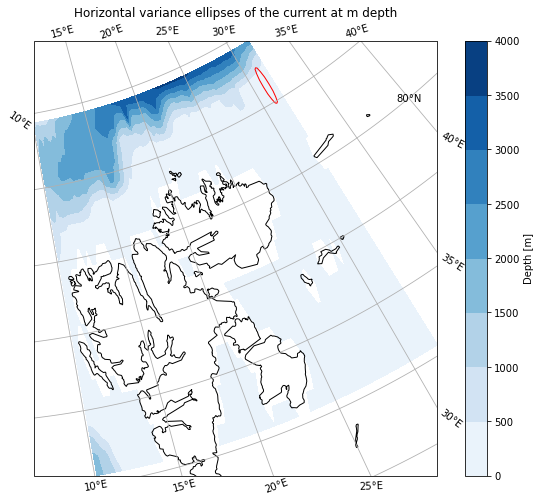

In [15]:
# Plot level 1
fig, ax = plt.subplots(1, 1,
                       figsize=(10, 8),
                       subplot_kw={"projection" : ccrs.NorthPolarStereo()}
                      )
plt.title('Horizontal variance ellipses of the current at m depth')
ax.coastlines()
ax.gridlines(lw=2, ec='black', draw_labels=True)
c = ax.contourf(depth_b.lon, depth_b.lat, depth_b,
                transform=ccrs.PlateCarree(),
                #colors="black",
                #levels=5,
                cmap="Blues"
                )
#for vel in vel_l[0]:
#    for p in p_list[0]:
vel = vel_l[1]
p = p_list[1]
depth = -1
u = vel[0]#.isel(nDEPTH=depth).mean('TIME')
v = vel[1]#.isel(nDEPTH=depth).mean('TIME')
lon = p[0]
lat = p[1]

maj_, min_, theta_ = ellipser_b(u,v,depth)
ellipse = Ellipse((lon,lat), 
        width = maj_*2, 
        height = min_*2,
        angle = theta_,
        facecolor = 'none',
        edgecolor='r'
        , transform=ccrs.PlateCarree())
print(ellipse)
ax.add_patch(ellipse)

fig.colorbar(c,
             shrink=1,
             label=r"Depth [m]"
            )
    
ax.set_aspect('equal')
#fig.tight_layout()

In [16]:
def ellipser(u,v,depth):
    uvar = u.isel(DEPTH=depth).var('TIME') - (u.isel(DEPTH=depth).mean('TIME'))**2
    vvar = v.isel(DEPTH=depth).var('TIME') - (v.isel(DEPTH=depth).mean('TIME'))**2
    uv = u.isel(DEPTH=depth).var('TIME')*v.isel(DEPTH=depth).var('TIME') - u.isel(DEPTH=depth).mean('TIME')*v.isel(DEPTH=depth).mean('TIME')
    
    covm = np.array([[uvar,uv],
                [uv,vvar]],dtype=float)
    values_, vectors_ = np.linalg.eig(covm)
    order = values_.argsort()[::-1]
    values, vectors = values_[order], vectors_[:, order]
    
    # ellipser :
    major = np.sqrt(values[0])#*0.001
    minor = np.sqrt(np.abs(values[1]))#*0.001

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = vectors[:,0][0], vectors[:,0][1]
    #theta = np.arctan(vy/vx)#*(180/math.pi)
    theta = np.arctan2(vy, vx)*(180/math.pi)
   
    return major, minor, theta

3
Ellipse(xy=(11.1189, 69.5289), width=0.30484701719090224, height=0.2626004043182453, angle=-43.9530066017608)
4
Ellipse(xy=(13.16845, 68.58759), width=0.27917143866799704, height=0.13576510098782013, angle=-43.503019267992784)
5
Ellipse(xy=(13.19866, 68.56109), width=0.2932417605266341, height=0.22999003844622554, angle=-44.17486238004568)
6
Ellipse(xy=(12.45082, 68.50128), width=0.2844208463869307, height=0.15596381181463032, angle=-50.59033398053498)


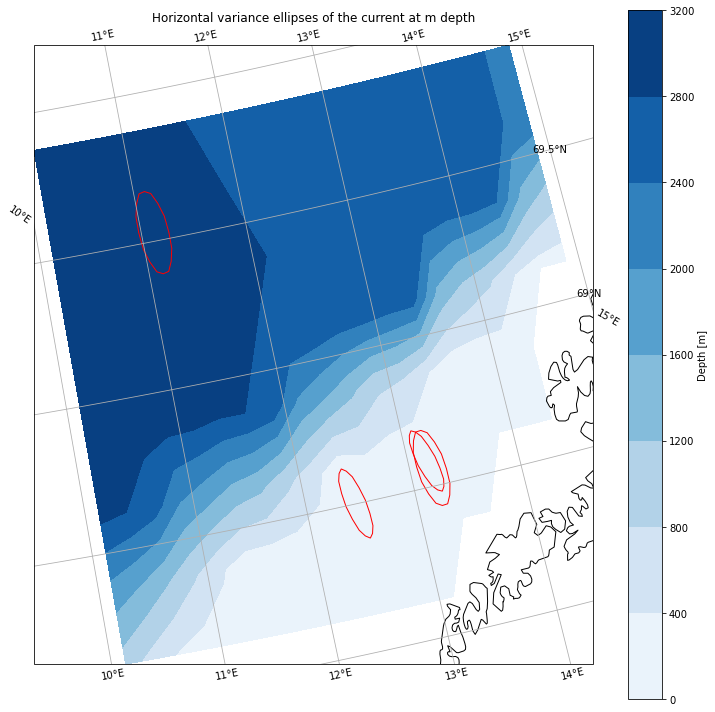

In [17]:
# Plot level 1
fig, ax = plt.subplots(1, 1,
                       figsize=(10, 10),
                       subplot_kw={"projection" : ccrs.NorthPolarStereo()}
                      )
plt.title('Horizontal variance ellipses of the current at m depth')
ax.coastlines()
ax.gridlines(lw=2, ec='black', draw_labels=True)
c = ax.contourf(depth_l.lon, depth_l.lat, depth_l,
                transform=ccrs.PlateCarree(),
                #colors="black",
                #levels=5,
                cmap="Blues"
                )

for i in [3,4,5,6]:
    print(i)
    vel = vel_l[i]
    p = p_list[i]
    u = vel[0]
    v = vel[1]
    lon = p[0]
    lat = p[1]
    depth = 20
    maj_, min_, theta_ = ellipser(u,v,depth)
    ellipse = Ellipse((lon,lat), 
            width = maj_*2, 
            height = min_*2,
            angle = theta_,
            facecolor = 'none',
            edgecolor='r'
            , transform=ccrs.PlateCarree())
    print(ellipse)
    ax.add_patch(ellipse)

fig.colorbar(c,
             shrink=1,
             label=r"Depth [m]"
            )
    
ax.set_aspect('equal')
fig.tight_layout()

3
Ellipse(xy=(0.2, 0.2), width=0.30484701719090224, height=0.2626004043182453, angle=-43.9530066017608)
4
Ellipse(xy=(0.4, 0.6), width=0.27917143866799704, height=0.13576510098782013, angle=-43.503019267992784)
5
Ellipse(xy=(0.2, 0.5), width=0.2932417605266341, height=0.22999003844622554, angle=-44.17486238004568)
6
Ellipse(xy=(0.3, 0.4), width=0.2844208463869307, height=0.15596381181463032, angle=-50.59033398053498)


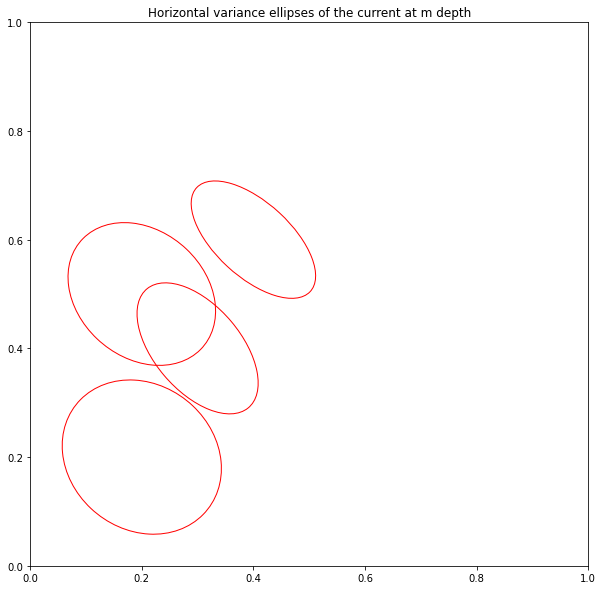

In [18]:
# Plot level 1
fig, ax = plt.subplots(1, 1,
                       figsize=(10, 10)
                       #,subplot_kw={"projection" : ccrs.NorthPolarStereo()}
                      )
plt.title('Horizontal variance ellipses of the current at m depth')
#ax.coastlines()
#ax.gridlines(lw=2, ec='black', draw_labels=True)
#c = ax.contourf(depth_l.lon, depth_l.lat, depth_l,
#                transform=ccrs.PlateCarree(),
#                #colors="black",
#                #levels=5,
#                cmap="Blues"
#                )
pl = [(0,0),(0,0),(0,0),(0.2,0.2), (0.4,0.6), (0.2,0.5), (0.3,0.4)]

for i in [3,4,5,6]:
    print(i)
    vel = vel_l[i]
    p = pl[i]
    u = vel[0]
    v = vel[1]
    lon = p[0]
    lat = p[1]
    depth = 20
    maj_, min_, theta_ = ellipser(u,v,depth)
    ellipse = Ellipse((lon,lat), 
            width = maj_*2, 
            height = min_*2,
            angle = theta_,
            facecolor = 'none',
            edgecolor='r'
            #, transform=ccrs.PlateCarree()
                     )
    print(ellipse)
    ax.add_patch(ellipse)

#fig.colorbar(c,
#             shrink=1,
#             label=r"Depth [m]"
#            )
    
#ax.set_aspect('equal')
#fig.tight_layout()

### Projecting data along bathymetry

Length in meters of 1° of latitude = always 111.32 km

Length in meters of 1° of longitude = 40075 km * cos( latitude ) / 360

In [27]:
density = ds_rho.I_an.sel(lat=slice(67, 90), lon=slice(-30,35))

depth = density.idxmax(dim="depth", skipna=True)
depth = depth.drop_vars("time")

In [198]:
# the difference between each step in lat, lon
lon_.diff(dim='lon')
lat_.diff(dim='lat')

<xarray.DataArray 'lat' (lat: 91)>
array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25], dtype=float32)
Coordinates:
  * lat      (lat) float32 67.38 67.62 67.88 68.12 ... 89.12 89.38 89.62 89.88

In [199]:
LAT, LON = np.meshgrid(depth.lat,depth.lon)

dy = 0.25*111.32e3 # 0.25 pga step between each point 
dx = np.zeros(len(depth.lat))

R = 6.3781e6 # Earth radius 

for i, latt in enumerate(depth.lat):
    dx[i] = (np.pi*0.25/180)*R*np.cos(np.deg2rad(latt))
    

print(dy)
dx

27830.0


array([10818.01942958, 10706.03767633, 10593.85106374, 10481.46373877,
       10368.87653081, 10256.08861046, 10143.10910101, 10029.93551429,
        9916.57199726,  9803.0193793 ,  9689.27683103,  9575.35264634,
        9461.24682523,  9346.9601971 ,  9232.4960795 ,  9117.85281366,
        9003.03952286,  8888.05454833,  8772.90037823,  8657.57535378,
        8542.08942767,  8426.44094112,  8310.6315529 ,  8194.66458057,
        8078.53836536,  7962.26120117,  7845.8322586 ,  7729.25402582,
        7612.52899101,  7495.65549539,  7378.64266224,  7261.48883278,
        7144.19732458,  7026.76979642,  6909.20500421,  6791.51165654,
        6673.68933873,  6555.74012424,  6437.66608655,  6319.46598157,
        6201.14893261,  6082.71411026,  5964.1631733 ,  5845.49860992,
        5726.7195907 ,  5607.83482426,  5488.84348121,  5369.74722031,
        5250.54604157,  5131.24782421,  5011.85173881,  4892.36027357,
        4772.77591664,  4653.09742395,  4533.33350408,  4413.48332765,
      

In [210]:
dx.shape

(92,)

In [211]:
#dy_l = np.linspace(int(dy),int(dy),len(depth.lat))

#d_xy = np.meshgrid(dx,dy_l)


In [41]:
# Change in depth along lat and long 
d_hb_lat = depth.diff(dim='lat')#.fillna(0)
d_hb_lon = depth.diff(dim='lon')#.fillna(0)

In [265]:
d_hb_lon.shape

(92, 259)

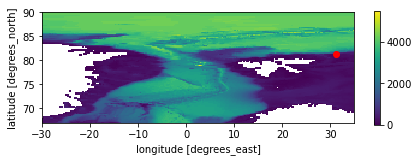

In [221]:
fig, ax = plt.subplots(figsize=(7,7))
b = depth.plot(add_colorbar=False)
ax.plot(p[0],p[1], marker='o',color='r')
ax.set_aspect('equal')
fig.colorbar(b,
            shrink=0.3,
            )


In [264]:
p[0]

31.13247

In [240]:
depth

<xarray.DataArray 'depth' (lat: 92, lon: 260)>
array([[ 200.,  250.,  250., ...,   nan,   nan,   nan],
       [ 175.,  200.,  200., ...,   nan,   nan,   nan],
       [ 275.,  250.,  225., ...,   nan,   nan,   nan],
       ...,
       [4100., 4100., 4100., ..., 4100., 4100., 4100.],
       [4200., 4200., 4200., ..., 4100., 4100., 4100.],
       [4200., 4200., 4200., ..., 4100., 4100., 4100.]])
Coordinates:
  * lat      (lat) float32 67.12 67.38 67.62 67.88 ... 89.12 89.38 89.62 89.88
  * lon      (lon) float32 -29.88 -29.62 -29.38 -29.12 ... 34.38 34.62 34.88

In [244]:
#depth.isel(lon=int(p[0]),lat=int(p[1]))

In [250]:
'Making a function for the vertical PC'
def PCz_op(up,vp, p_lat, p_lon):
        
    dy_ = dy
    for i,lat in enumerate(depth.lat): 
        if lat==p_lat:
            dx_ = dx[i]        
            for j,lon in enumerate(depth.lon): 
                if lon==p_lon:
                    hb_lonp = d_hb_lon[i,j]
                    hb_latp = d_hb_lat[i,j]
    
    # lag lengde scalar av bathym og dele u_o og u_p på 

    vel_ort = (up*(hb_lonp/dx_) + vp*(hb_lonp/dy_))/np.sqrt(hb_lonp**2 + hb_latp**2) # delt på lengden av bathymetrien
    vel_par = (up*(hb_latp/dy_)  - vp*(d_hbx_p/dx_))/np.sqrt(hb_lonp**2 + hb_latp**2)

    cov_o = np.cov(vel_ort.T, bias=True) # uten .T ble den en 73x73 matrise 
    cov_p = np.cov(vel_par.T, bias=True)
    
    values_o, vectors_o = np.linalg.eig(cov_o)
    order_o = values_o.argsort()[::-1]
    values_o, vectors_o = values_o[order_o], vectors_o[:, order_o]
    values_p, vectors_p = np.linalg.eig(cov_p)
    order_p = values_p.argsort()[::-1]
    values_p, vectors_p = values_p[order_p], vectors_p[:, order_p]
    
    PCp = np.sqrt(values_p[0])*vectors_p[:,0]
    PCo = np.sqrt(values_o[0])*vectors_o[:,0]
    
    return PCp, PCo

In [249]:
#p_list

UnboundLocalError: local variable 'hb_lonp' referenced before assignment

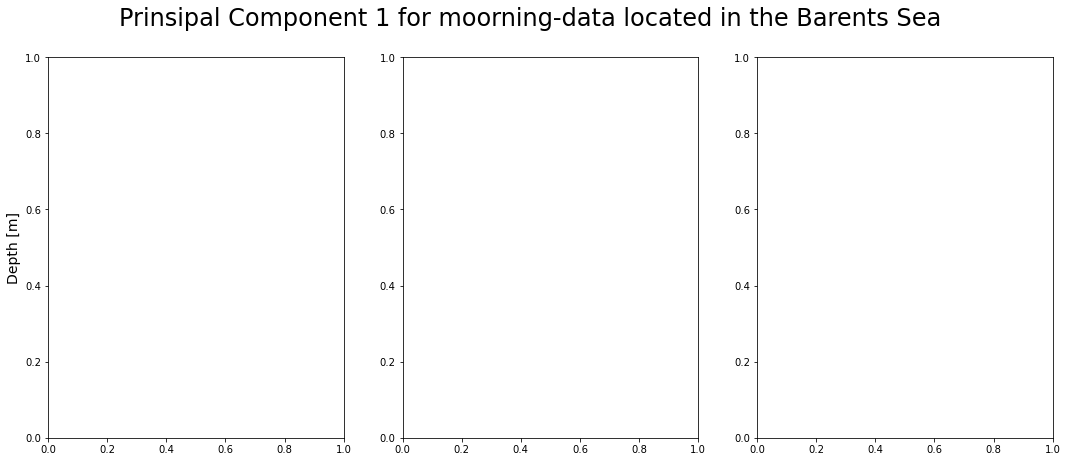

In [251]:
fig, axs = plt.subplots(1,3,figsize=(18,7))
yl = [(u13,v13),(u15,v15),(u17,v17)]

plt.suptitle('Prinsipal Component 1 for moorning-data located in the Barents Sea ', 
             horizontalalignment='center',
            fontsize=24)

axs[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axs.flat, range(len(yl))):
    y = yl[i]
    U =y[0]
    V = y[1]
    p = p_list[i]
    PCp, PCo = PCz_op(U,V,p[1],p[0])
    axs.plot(PCp,U.nDEPTH*4, 'g', label = 'Velocity parallel')
    axs.plot(PCo,U.nDEPTH*4, 'r', label = 'Velocity orthogonal')
    axs.axvline(0, color='k', linestyle = '--')
    axs.invert_yaxis()
    axs.set_xlabel('Variance in current speed [cm^2/m^2]', fontsize=14)
    axs.legend(frameon=False, fontsize=14, loc="upper left") 
fig.tight_layout()

In [259]:
float(lat.values)

89.875

In [261]:
for i,lat in enumerate(depth.lat): 
    print(float(lat.values))
    print(p[1])
    if float(lat.values) == p[1]: # they are not equal, need to apply something for approximate equal 
        print('ok')

67.125
81.24202
67.375
81.24202
67.625
81.24202
67.875
81.24202
68.125
81.24202
68.375
81.24202
68.625
81.24202
68.875
81.24202
69.125
81.24202
69.375
81.24202
69.625
81.24202
69.875
81.24202
70.125
81.24202
70.375
81.24202
70.625
81.24202
70.875
81.24202
71.125
81.24202
71.375
81.24202
71.625
81.24202
71.875
81.24202
72.125
81.24202
72.375
81.24202
72.625
81.24202
72.875
81.24202
73.125
81.24202
73.375
81.24202
73.625
81.24202
73.875
81.24202
74.125
81.24202
74.375
81.24202
74.625
81.24202
74.875
81.24202
75.125
81.24202
75.375
81.24202
75.625
81.24202
75.875
81.24202
76.125
81.24202
76.375
81.24202
76.625
81.24202
76.875
81.24202
77.125
81.24202
77.375
81.24202
77.625
81.24202
77.875
81.24202
78.125
81.24202
78.375
81.24202
78.625
81.24202
78.875
81.24202
79.125
81.24202
79.375
81.24202
79.625
81.24202
79.875
81.24202
80.125
81.24202
80.375
81.24202
80.625
81.24202
80.875
81.24202
81.125
81.24202
81.375
81.24202
81.625
81.24202
81.875
81.24202
82.125
81.24202
82.375
81.24202
82.625
8

In [257]:

dy_ = dy
for i,lat in enumerate(depth.lat): 
    print(lat)
    if lat==p[1]:
        dx_ = dx[i] 
        print(dx_)
        for j,lon in enumerate(depth.lon): 
            if lon==p[0]:
                hb_lonp = d_hb_lon[i,j]
                hb_latp = d_hb_lat[i,j]
                print(hb_latp)

<xarray.DataArray 'lat' ()>
array(67.125, dtype=float32)
Coordinates:
    lat      float32 67.12
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
    bounds:         lat_bnds
    _ChunkSizes:    720
<xarray.DataArray 'lat' ()>
array(67.375, dtype=float32)
Coordinates:
    lat      float32 67.38
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
    bounds:         lat_bnds
    _ChunkSizes:    720
<xarray.DataArray 'lat' ()>
array(67.625, dtype=float32)
Coordinates:
    lat      float32 67.62
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
    bounds:         lat_bnds
    _ChunkSizes:    720
<xarray.DataArray 'lat' ()>
array(67.875, dtype=float32)
Coordinates:
    lat      float32 67.88
Attributes:
    standard_name:  latitude
    long_name:      latitude
    u

In [254]:
hb_latp

NameError: name 'hb_latp' is not defined